In [1]:
import torch
import torch.autograd as autograd         
from torch import Tensor                  
import torch.nn as nn                     
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         
import scipy.io

In [2]:
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cpu


In [27]:
def plot3D(x,t,y):
    x_plot =x.squeeze(1) 
    t_plot =t.squeeze(1)
    X,T= torch.meshgrid(x_plot,t_plot)
    F_xt = y
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('F(x,t)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('f(x,t)')
    plt.show()
    
def plot3D_Matrix(x,t,y):
    X,T= x,t
    F_xt = y
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('F(x,t)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('f(x,t)')
    plt.show()
    
def solutionplot(u_pred,X_u_train,u_train):
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,usol.T[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.25s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75s$', fontsize = 10)
    
    plt.savefig('Burgers.png',dpi = 500)

In [4]:
x=torch.linspace(-1,1,2000).view(-1,1)
t=torch.linspace(0,1,1000).view(-1,1)

X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))


C:\Users\atuly\anaconda3\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# Transform the mesh into a 2-column vector

x_test=torch.hstack((X.transpose(1,0).flatten().reshape(-1,1),T.transpose(1,0).flatten().reshape(-1,1)))

print(x_test.shape)

torch.Size([2000000, 2])


In [6]:
#x(x,0)=sin(pix)->xmin=<x=<xmax; t=0
left_X=torch.hstack((X[:,0].reshape(-1,1),T[:,0].reshape(-1,1))) # First column 
left_Y=torch.sin(np.pi*left_X[:,0]).unsqueeze(1)

#x=min; tmin=<t=<max
top_X=torch.hstack((X[0,:].reshape(-1,1),T[0,:].reshape(-1,1))) # First row 
top_Y=torch.zeros(top_X.shape[0],1)

#x=max; 0=<t=<1
bottom_X=torch.hstack((X[-1,:].reshape(-1,1),T[-1,:].reshape(-1,1))) # Last row 
bottom_Y=torch.zeros(bottom_X.shape[0],1)

X_train=torch.vstack([left_X,bottom_X,top_X])
Y_train=torch.vstack([left_Y,bottom_Y,top_Y])

#Choose points of our available training data:
idx=np.random.choice(X_train.shape[0],100,replace=False)
X_train_Nu=X_train[idx,:]
Y_train_Nu=Y_train[idx,:]

lb=x_test[0] 
ub=x_test[-1]

X_train_Nf = np.linspace(lb,ub,10000)
X_train_Nf = torch.from_numpy(X_train_Nf)

f_hat = torch.zeros(10000,1).to(device)

In [20]:
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__() 
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0 
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)   
    
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    
    def lossBC(self,x_BC,y_BC):
            loss_BC=self.loss_function(self.forward(x_BC),y_BC)
            return loss_BC

    def lossPDE(self,x_PDE):
        g = x_PDE.clone()
                        
        g.requires_grad = True
        
        u = self.forward(g)
                
        u_x_t = autograd.grad(u,g,torch.ones([x_PDE.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(x_PDE.shape).to(device), create_graph=True)[0]
                                                            
        u_x = u_x_t[:,[0]]
        
        u_t = u_x_t[:,[1]]
        
        u_xx = u_xx_tt[:,[0]]
                                        
        f = u_t + (self.forward(g))*(u_x) - (0.01/np.pi)*u_xx 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    

    def loss(self,x_BC,y_BC,x_pde):
            loss_bc=self.lossBC(x_BC,y_BC)
            loss_pde = self.lossPDE(x_pde)
            return loss_bc + loss_pde


In [21]:
layers = np.array([2,32,32,1])

PINN = FCN(layers)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=1e-3,amsgrad=False)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [22]:
for i in range(20000):
    if i==0:
        print("Training Loss-----Test Loss")
    loss = PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf) # use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Training Loss-----Test Loss


In [23]:
y1=PINN(x_test)

In [24]:
x1=x_test[:,0]
t1=x_test[:,1]

In [36]:
arr_x1=x1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=X.shape).transpose(1,0).detach().cpu() 

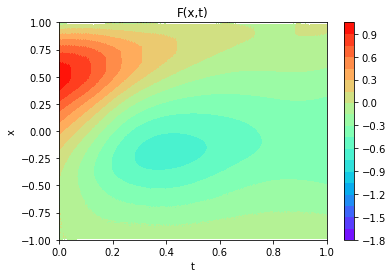

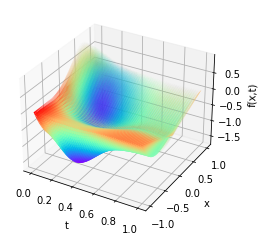

In [37]:
plot3D_Matrix(arr_x1,arr_T1,arr_y1)